In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim

from stacksyms import parseELF, parseDWARF, getAllFunctions, collectFrameInfo, \
                      assign_frames, processRegisterRuleExpressions, propagateTypeInfo, \
                      collectOpcodes, collectDisassemblyObjdump, checkLabels

#filepath = 'data/binary/x86/gcc-32-O1-utillinux-unshare'
#filepath = 'data/cross-compile-dataset/bin/static/gcc/o1/pee'
#filepath = 'data/cross-compile-dataset/bin/static/gcc/og/parallel'
#filepath = 'data/cross-compile-dataset/bin/dynamic/clang/o3/xrdb'
#filepath = 'data/cross-compile-dataset/bin/static/gcc/og/sum'
#filepath = 'data/spec2006/bzip2'
filepath = 'data/alias-11-gcc-o3'

In [ ]:
functions = parseELF(filepath)
print(len(functions))

In [ ]:
#import logging; logging.getLogger().setLevel(logging.DEBUG)
from stacksyms import getMaxFrameSize, getMaxFrameSizeCFA, generateDebugLabel, getStackElements, getStackLocations, getMaxStackOff
doesntwork = []
for func in functions:
    cfa   = getMaxFrameSizeCFA(func)
    frame = getMaxFrameSize(func)
    label = generateDebugLabel(func)
    # compressStream acc.to GDB's "info scope": [4, 4, -, -, -, 4, 4, 4, 4, 4, 4, 4, 4, -, -, 5000]
    # compressStream acc.to params+locals+regs: [4, 4, 4, 5000, 32, 32, 8, 8, 8, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 148, 148]
    if None in label:
        print("BUG!!!!!!!!", func.name)
        print([(stkElm, stkElm.type.qualified_name, stkElm.type.byte_size) for stkElm in getStackElements(func)])
        break
    if sum(label) != frame:
        doesntwork += [func]
    print(f"{func.name} (frame starts at {func.frame_base}, size is {cfa}/{frame}/{sum(label)} bytes by cfa/offset/sum) => {label}")
    if 0<len(func.inlined_functions):
        print("    inlines ", func.inlined_functions)
        for inlined in func.inlined_functions:
            print("        ", inlined.name, getMaxFrameSize(inlined), generateDebugLabel(inlined))
        break

In [ ]:
# In principle, on x86 we can read out the stack size of a function from the
# .eh_frame section as follows:
# 1) "nm elf_binary | grep function_name" -> note address
# 2) "readelf --debug-dump=frames-interp | grep -A10 'address..'"
#    -> read off maximum stack offset from last entry under CFA column
# The problem is that this doesn't work on architectures that do not store the
# return address on the stack and even on x86 some compiler passes may result in
# code that will try to hold the return address in a register, even though it is
# stored on the stack (e.g., "gcc-32-O1-utillinux-unshare")
from elftools.elf.elffile import ELFFile

elf = ELFFile(open(filepath, 'rb'))
module, importer = parseDWARF(elf)
func_dict = getAllFunctions(module, importer, elf)

In [ ]:
frame_tables = collectFrameInfo(func_dict, elf)
func_dict = assign_frames(frame_tables, func_dict)
func_dict = processRegisterRuleExpressions(func_dict, importer)
func_dict = propagateTypeInfo(func_dict, importer)
func_dict = collectOpcodes(func_dict, elf)
#labels = checkLabels(functions)

In [ ]:
# modified mainDriver.py to only print the number of functions to stdout, then:
# python3 ./mainDriver.py --dataroot data/cross-compile-dataset/bin/static/gcc/og 2> /dev/null > number_of_functions.txt
# grep -v "\[-\]" number_of_functions.txt | cut -d$'\t' -f2 | paste -sd+ | bc
import numpy as np
file2nofuns = dict()
with open('number_of_functions.txt','r') as nofuns:
    for line in nofuns.readlines():
        if not line[0:3]=='[-]':
            file, nofuns = line.split('\t')
            file2nofuns[file[:-1]] = int(nofuns)
nofuns = list(file2nofuns.values())
print(sum(nofuns), np.mean(nofuns), np.std(nofuns))

In [16]:
import os

def parse_framesizes(filepath):
    func2size = dict()
    multiples = []
    for subdir, dirs, files in os.walk(filepath):
        for file in files:
            with open(os.path.join(filepath, file),'r') as f:
                for line in f.readlines():
                    source, stacksize, boundtype = map(str.strip, line.split('\t'))
                    colons = [index for index, letter in enumerate(source) if letter==':']
                    function = os.path.join(filepath, file) + ':' + source
                    stacksize = int(stacksize)
                    if function in func2size and func2size[function] != (stacksize, boundtype):
                        multiples += [(function, stacksize, boundtype)]
                        #print(f"{function} with {(stacksize, boundtype)} was already recorded as {func2size[function]}!")
                        continue
                    func2size[function] = (stacksize, boundtype)
    return func2size, multiples

In [29]:
import numpy as np
gcc_coreutils_O3, multiples = parse_framesizes('data/stackbert-dataset/GCC/64/coreutils/O3-su')
print("multiples: ", len(multiples))

def by_boundtype(func2size):
    static_sizes = [size for size,boundtype in func2size.values() if boundtype=='static']
    dynamic_sizes = [size for size,boundtype in func2size.values() if boundtype=='dynamic,bounded']
    unbounded_sizes = [size for size,boundtype in func2size.values() if boundtype=='dynamic']
    return static_sizes, dynamic_sizes, unbounded_sizes

static_sizes, dynamic_sizes, unbounded_sizes = by_boundtype(gcc_coreutils_O3)
print(f"static sizes: number={len(static_sizes)}, avg={np.mean(static_sizes)}, std={np.std(static_sizes)}")
print(f"dynamic sizes: number={len(dynamic_sizes)}, avg={np.mean(dynamic_sizes)}, std={np.std(dynamic_sizes)}")
print(f"unbounded: number={len(unbounded_sizes)}, avg={np.mean(unbounded_sizes)}, std={np.std(unbounded_sizes)}")


multiples:  0
static sizes: number=1407, avg=344.5685856432125, std=2814.4032341536813
dynamic sizes: number=148, avg=299.8918918918919, std=519.2131148024935
unbounded: number=9, avg=496.0, std=360.46389863927044


In [35]:
print([(fun,size) for fun,(size,boundtype) in gcc_coreutils_O3.items() if boundtype=='dynamic,bounded'])

[('data/stackbert-dataset/GCC/64/coreutils/O3-su/comm.su:src/comm.c:254:1:compare_files', 560), ('data/stackbert-dataset/GCC/64/coreutils/O3-su/comm.su:src/comm.c:407:1:main', 48), ('data/stackbert-dataset/GCC/64/coreutils/O3-su/rm.su:src/rm.c:209:1:main', 256), ('data/stackbert-dataset/GCC/64/coreutils/O3-su/cp.su:src/cp.c:933:1:main', 352), ('data/stackbert-dataset/GCC/64/coreutils/O3-su/mv.su:src/mv.c:337:1:main', 352), ('data/stackbert-dataset/GCC/64/coreutils/O3-su/install.su:src/install.c:408:1:process_dir', 80), ('data/stackbert-dataset/GCC/64/coreutils/O3-su/basenc-basenc.su:src/basenc.c:1086:1:main', 176), ('data/stackbert-dataset/GCC/64/coreutils/O3-su/tail.su:src/tail.c:2339:1:main', 720), ('data/stackbert-dataset/GCC/64/coreutils/O3-su/b2sum-md5sum.su:src/md5sum.c:861:1:main', 352), ('data/stackbert-dataset/GCC/64/coreutils/O3-su/chown.su:src/chown.c:157:1:main', 288), ('data/stackbert-dataset/GCC/64/coreutils/O3-su/chown-core.su:src/chown-core.c:511:1:chown_files', 80), ('

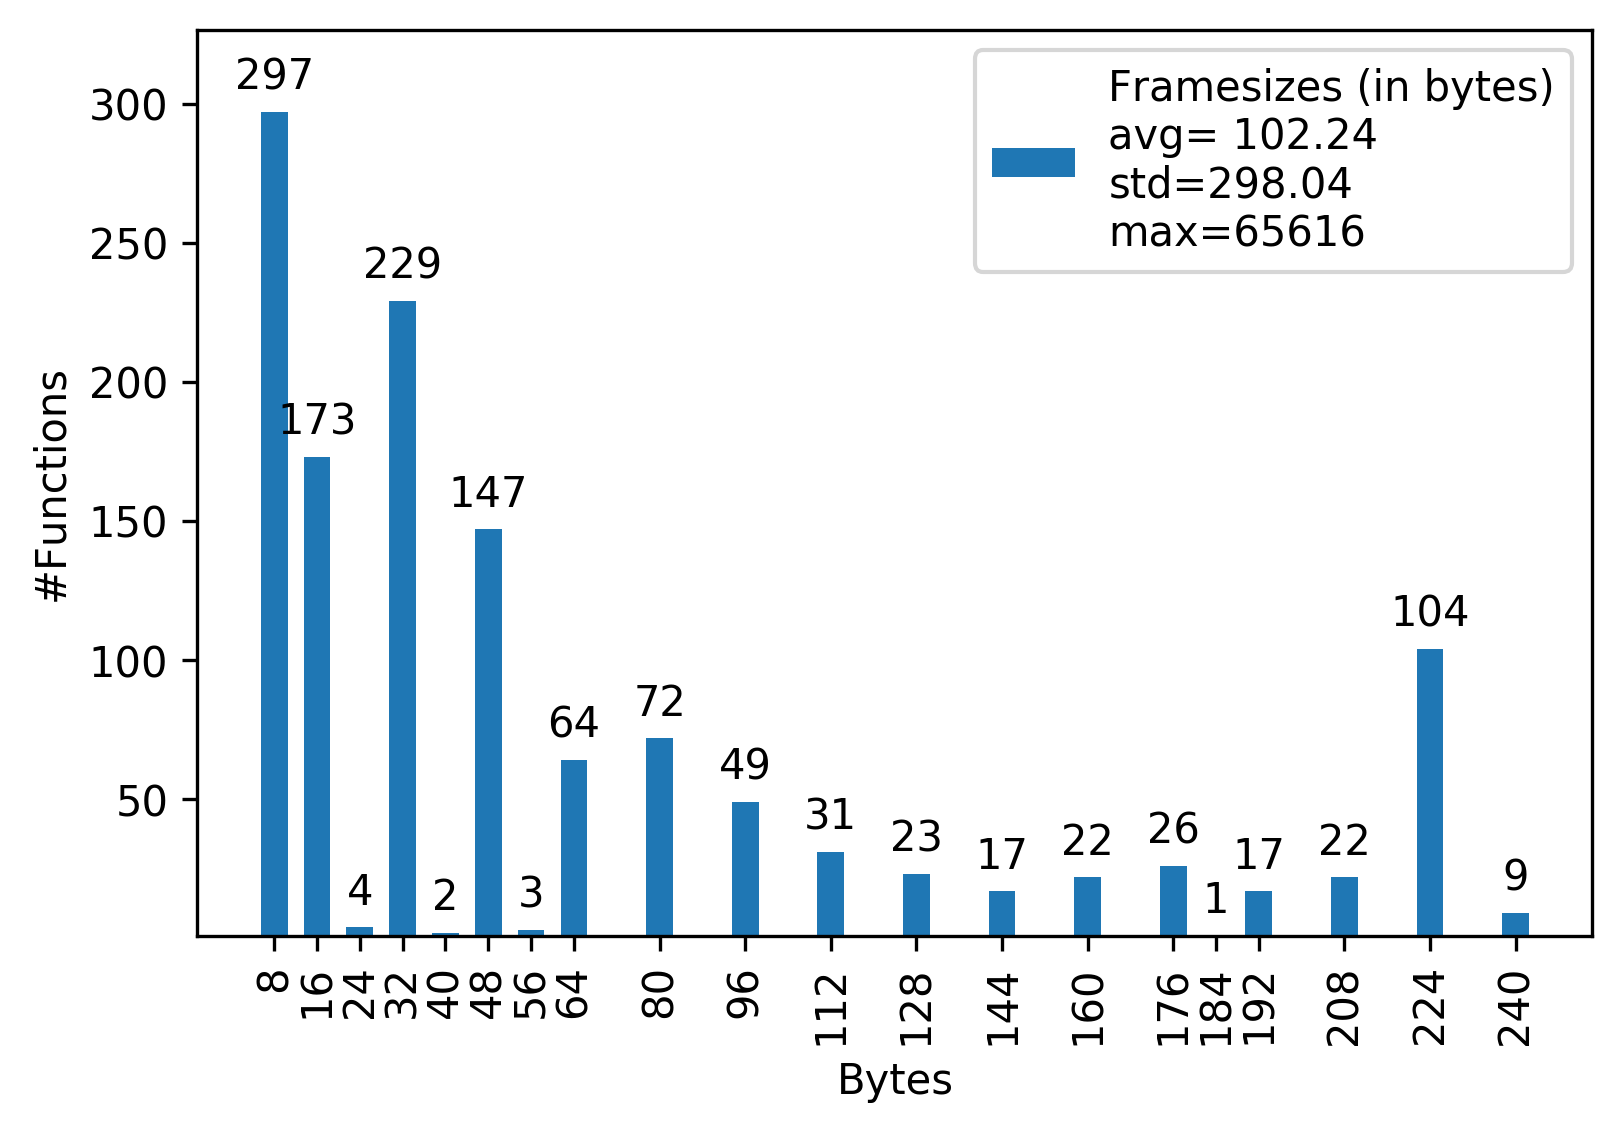

In [45]:
def plot_framesizes(framesizes, title, xlimit=16):
    import matplotlib.pyplot as plt
    from matplotlib.ticker import FormatStrFormatter
    framesizes = np.array(framesizes)
    bins, counts = map(list,np.unique(framesizes, return_counts=True))
    bins, counts = bins[:xlimit], counts[:xlimit]
    maxbin, maxcount = max(bins), max(counts)
    minbin, mincount = min(bins), min(counts)
    xscale, yscale = (maxbin-minbin)/100, (maxcount-mincount)/100
    avg, std = np.mean(framesizes[framesizes < 8192]), np.std(framesizes[framesizes < 8192])
    fig, ax = plt.subplots(dpi=300) #figsize=(800,600))#,
    ax.bar(bins, counts, width=5, label=f'Framesizes (in bytes)\navg= {avg:0.2f}\nstd={std:0.2f}\nmax={max(framesizes)}')
    ax.set_ylabel('#Functions')
    ax.set_xlabel('Bytes')
    if not title is None:
        ax.set_title(title)
    ax.set_xticks(bins)
    ax.set_ylim(mincount, maxcount + 10*yscale)
    #ax.set_xlim(0, maxbin + 10*xscale)
    ax.set_xticklabels(bins)
    ax.legend()
    for rect, count in zip(ax.patches, counts):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height+5, count, ha='center', va='bottom')
    plt.setp(ax.get_xticklabels(), rotation=90, ha='center')
    return fig
    #plt.show()

fig = plot_framesizes(static_sizes, title=None, xlimit=20)
#fig.savefig('../papers-and-presentations/202103-stacksymbolization/ccs21/images/static_coreutils_gcc_O3.pdf', bbox_inches='tight', format='pdf')
#plot_framesizes(dynamic_sizes, title='Binutils Bounded Framesizes by Function (-O3 LLVM 13.0.0)')
#plot_framesizes(static_sizes, title='Coreutils Static Framesizes by Function (-O2 GCC 11.1.0)', xlimit=20)

In [ ]:
#PAD_TOK8  = 0xa1 # 1 byte isn't super reliable.. might actually appear in instructions
PAD_TOK16 =  0x0f78 # vmread (0x0f79 is vmwrite, could also use 'UD2' 0x0f0b)
TOK_LEN = 2 # a token is two bytes
PAD_TOK = PAD_TOK16
MAX_INST_LEN = 16 # pretty sure 128 bits is the limit on x86

def tokenize(features):
    return [[int(x[i:i+2*TOK_LEN], 16) for i in range(0,len(x),2*TOK_LEN)] for x in features]

def funcFeatures(function): # features are instructions (16 bytes max)
    return tokenize(map(lambda t : t[1].replace(' ', ''), function.disas))

def generatePositionalEncodings(function): # code addresses
    return list(map(lambda t : t[0][0:18], function.disas))

for func in functions:
    if 0<len(func.disas):
        print()

In [ ]:
X, Y, Z = [], [], []
for func in functions:
    print('////////////////////////')
    print(func.name, hex(func.start), func.frame_base)
    for lvar in func.variables:
        print(lvar.name, lvar.type, "(bytesize = %d)"%lvar.type.byte_size)
        for loc in lvar.locations:
            print(hex(loc.begin) + " to " + hex(loc.end) + ": " \
            + str(loc.type)[13:]
            + str(loc.expr))
        print('')
#    X += [func] #generateFeature(func, functions)]
#    Y += [generateLabel(func, functions)]
#    Z += [generateDebugLabel(func, functions)]
#print([x+" => "+ str(y) for x,y in zip(X,Z)])

#func = 'quotearg_n_style_colon'

In [ ]:
'''Doesnt appear to be super useful for stack symbolization as compilers dont seem to emit relevant information'''
def handleLineprogram(dwarfInfo):
    print('looping through compilation units..')
    for cu in dwarfInfo.iter_CUs():
        lp = dwarfInfo.line_program_for_CU(cu)
        if lp == None:
            print('DWARF info is missing a line program for this CU')
            print(cu.keys())
            continue
        cu_filename = lp['file_entry'][0].name.decode('latin-1')
        if len(lp['include_directory']) > 0:
            dir_index = lp['file_entry'][0].dir_index
            if dir_index > 0:
                idir = lp['include_directory'][dir_index - 1]
            else:
                idir = b'.'
            cu_filename = '%s/%s' % (idir.decode('latin-1'), cu_filename)
        print(f'CU: {cu_filename}')
        #print(f'File name                            Line number    Starting address')
        for entry in lp.get_entries():
            '''
            if entry.state is None:
                # Special handling for commands that don't set a new state
                if entry.command == DW_LNS_set_file:
                    file_entry = lp['file_entry'][entry.args[0] - 1]
                    if file_entry.dir_index == 0:
                        # current directory
                        print('\n./%s:[++]' % (
                            file_entry.name.decode('latin-1')))
                    else:
                        print('\n%s/%s:' % (
                            lp['include_directory'][file_entry.dir_index - 1].decode('latin-1'),
                            file_entry.name.decode('latin-1')))
                elif entry.command == DW_LNE_define_file:
                    print('%s:' % (
                        lp['include_directory'][entry.args[0].dir_index].decode('latin-1')))
                elif entry.command in [DW_LNS_set_basic_block, DW_LNS_set_prologue_end, DW_LNS_set_isa]:
                    print('=============================')
                    print(repr(entry))
                    print('=============================')
                else:
                    print('=============================')
                    print('OTHER COMMAND: ' + str(entry))
                    print('=============================')
            elif not entry.state.end_sequence:
                # readelf doesn't print the state after end_sequence
                # instructions. I think it's a bug but to be compatible
                # I don't print them too.
                if lp['version'] < 4:
                    print('%-35s  %11d  %18s' % (
                        lp['file_entry'][state.file - 1].name.decode('latin-1'),
                        state.line,
                        '0' if state.address == 0 else
                            hex(state.address)))
                else:
                    print('%-35s  %11d  %18s[%d]' % (
                        lp['file_entry'][state.file - 1].name.decode('latin-1'),
                        state.line,
                        '0' if state.address == 0 else
                            hex(state.address),
                        state.op_index))
            if entry.command == DW_LNS_copy:
                # Another readelf oddity...
                print()
            '''
            if entry.command in [DW_LNS_set_basic_block, DW_LNS_set_prologue_end, DW_LNS_set_isa]:
                print('=============================')
                print(repr(entry))
                print('=============================')
        #print(dir(lp))
        #line_entry_mapping(lp)

def line_entry_mapping(line_program):
    import collections
    filename_map = collections.defaultdict(int)
    lp_entries = line_program.get_entries()
    for lpe in lp_entries:
        if not lpe.state or lpe.state.file == 0:
            continue # TODO: instruction doesn't correspond to src
        filename = lpe_filename(line_program, lpe.state.file)
        filename_map[filename] += 1
    for filename, lpe_count in filename_map.items():
        print('%s -> %d entries' % (filename, lpe_count))

def lpe_filename(line_program, file_index):
    lp_header = line_program.header
    print(lp_header)
    file_entries = lp_header["file_entry"]
    file_entry = file_entries[file_index - 1]
    dir_index = file_entry["dir_index"]
    if dir_index == 0:
        return file_entry.name.decode()
    directory = lp_header["include_directory"][dir_index - 1]
    return os.path.join(directory, file_entry.name).decode()

    

#print(elf.get_section_by_name('.text').data())